In [2]:
import faiss
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
from datasets import load_dataset, load_from_disk
from faiss import read_index, write_index
from sentence_transformers import SentenceTransformer

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
paraphs_parsed_dataset = load_from_disk("../input/all-paraphs-parsed-expanded")

In [4]:
df = pd.DataFrame(paraphs_parsed_dataset)

In [5]:
df.shape

(2101279, 3)

In [7]:
df["length"] = df["text"].apply(lambda x: len(x.split()))

In [16]:
import blingfire as bf
from pandarallel import pandarallel

pandarallel.initialize(progress_bar=True)


def extract_chunk_by_sliding_window(text: str, window_size: int, sliding_size: int) -> list[str]:
    """
    text のリストをsliding windowで結合する。window_size個のtextが含まれるまで結合し、sliding_size個ずつずらして結合する。
    """
    _, sentence_offsets = bf.text_to_sentences_and_offsets(text)
    text_list = []
    for o in sentence_offsets:
        if 3 < o[1] - o[0]:
            text_list.append(text[o[0] : o[1]])

    chunks = []
    for i in range(0, len(text_list), sliding_size):
        chunk = " ".join(text_list[i : i + window_size])
        chunks.append(chunk)
    return chunks


df["text"] = df["text"].parallel_apply(lambda x: extract_chunk_by_sliding_window(x, 4, 2))

INFO: Pandarallel will run on 12 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [17]:
explode_df = df.explode(["text"]).reset_index(drop=True)

<Axes: >

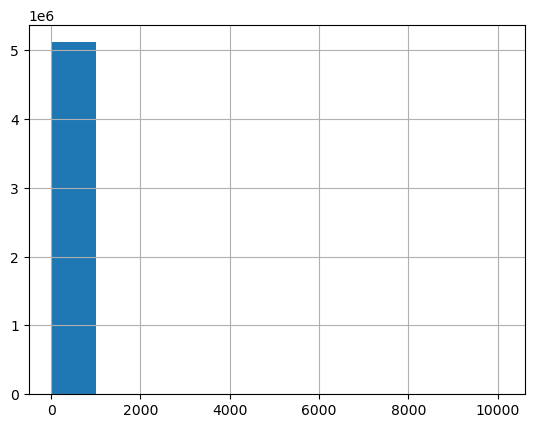

In [19]:
explode_df["length"] = explode_df["text"].apply(lambda x: len(x.split()))

<Axes: >

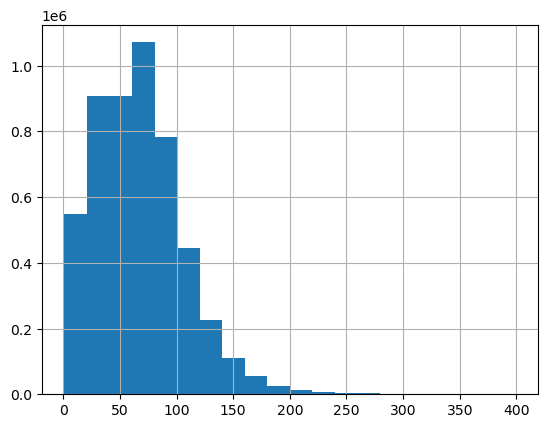

In [23]:
explode_df.loc[explode_df["length"] < 400, "length"].hist(bins=20)

In [5]:
df = pd.read_csv("../preprocessed/332_tfidf/000/train.csv")
a2 = np.load("../output/350_1st_infer/tfidf/data2_pred.npy")
df.iloc[96]

id                                                        96
prompt     Who proposed the concept of "maximal accelerat...
A                                                 Max Planck
B                                                 Niels Bohr
C                                      Eduardo R. Caianiello
D                                              Hideki Yukawa
E                                            Albert Einstein
answer                                                     C
context    Born reciprocity > Born reciprocity > However ...
Name: 96, dtype: object

In [6]:
a2[96]

array([1.5772917e-05, 1.5759566e-05, 9.9985933e-01, 9.4334922e-05,
       1.4752143e-05], dtype=float32)

In [4]:
df.iloc[96].context

'Born reciprocity > Born reciprocity > However Born\'s idea of a quantum metric operator was later taken up by Hideki Yukawa when developing his nonlocal quantum theory in the 1950s. In 1981, Eduardo R. Caianiello proposed a "maximal acceleration", similarly as there is a minimal length at Planck scale, and this concept of maximal acceleration has been expanded upon by others. It has also been suggested that Born reciprocity may be the underlying physical reason for the T-duality symmetry in string theory, and that Born reciprocity may be of relevance to developing a quantum geometry.Born chose the term "reciprocity" for the reason that in a crystal lattice, the motion of a particle can be described in p-space by means of the reciprocal lattice. Glossary of Lie groups and Lie algebras > M > maximal 1. For "maximal compact subgroup", see #compact. 2. For "maximal torus", see #torus. Laser > History > Laser In April 1957, Japanese engineer Jun-ichi Nishizawa proposed the concept of a "se

In [3]:
a1 = np.load("../test_predictions (2).npy")
a2 = np.load("../output/350_1st_infer/000/data2_pred.npy")

In [5]:
a1[0, :10]

array([5.0899638e-05, 1.6020971e-05, 2.6945649e-05, 9.9956685e-01,
       3.3927185e-04], dtype=float32)

In [6]:
a2[0, :10]

array([5.0899591e-05, 1.6021109e-05, 2.6945854e-05, 9.9956685e-01,
       3.3927124e-04], dtype=float32)

In [6]:
df = pd.read_parquet("../preprocessed/201_embedding/000/l.parquet")
sentence_embeddings = np.load("../preprocessed/201_embedding/000/l.npy").astype(np.float32, copy=False)

In [7]:
drop_idx = df["section_text"].str.startswith("Notes: &lt;")
sentence_embeddings = sentence_embeddings[~drop_idx]
df = df[~drop_idx].reset_index(drop=True)

In [8]:
df.shape, sentence_embeddings.shape

((1401590, 2), (1401590, 384))

In [9]:
df[df["id"] == "23473595"]

,id,section_text
1374970,23473595,Light-year: Distance that light travels in one...
1374971,23473595,"Definitions: As defined by the IAU, the light-..."
1374972,23473595,"Another value, , is the product of the J1900.0..."
1374973,23473595,History: The light-year unit appeared a few ye...
1374974,23473595,In 1868 an English journal labelled the light-...
1374975,23473595,Usage of term: Distances expressed in light-ye...
1374976,23473595,Related units: Distances between objects withi...


In [10]:
df[1374970:]

,id,section_text
1374970,23473595,Light-year: Distance that light travels in one...
1374971,23473595,"Definitions: As defined by the IAU, the light-..."
1374972,23473595,"Another value, , is the product of the J1900.0..."
1374973,23473595,History: The light-year unit appeared a few ye...
1374974,23473595,In 1868 an English journal labelled the light-...
...,...,...
1401585,24889426,Words taken directly from Latin and Ancient Gr...
1401586,24889426,List of English words with dual Old English/Ol...
1401587,24889718,Lefty (album): Lefty is the seventh solo studi...
1401588,24889826,List of United States federal courthouses in C...


In [11]:
train_df = pd.read_csv("../input/kaggle-llm-science-exam/train.csv")

train_df["answer_all"] = train_df.apply(lambda x: " ".join([x["A"], x["B"], x["C"], x["D"], x["E"]]), axis=1)
train_df["prompt_answer_stem"] = train_df["prompt"] + " " + train_df["answer_all"]

In [13]:
smodel = SentenceTransformer("BAAI/bge-small-en", device="cpu")
smodel.max_seq_length = 386
smodel.half()

SentenceTransformer(
  (0): Transformer({'max_seq_length': 386, 'do_lower_case': True}) with Transformer model: BertModel 
  (1): Pooling({'word_embedding_dimension': 384, 'pooling_mode_cls_token': True, 'pooling_mode_mean_tokens': False, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False})
)

In [15]:
question_embeddings = smodel.encode(
    [train_df.iloc[49].prompt_answer_stem],
    batch_size=8,
    device="cuda",
    show_progress_bar=True,
    # convert_to_tensor=True,
    normalize_embeddings=True,
)


num_include = 5

prompt_index = faiss.index_factory(sentence_embeddings.shape[1], "Flat")
prompt_index.add(sentence_embeddings[1374970:])
ss, ii = prompt_index.search(question_embeddings.astype("float32"), num_include)

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

In [16]:
ss

array([[0.08308185, 0.13949133, 0.16772568, 0.1909834 , 0.19430317]],
      dtype=float32)

In [17]:
sentence_embeddings[1374970:]

array([[-7.9574585e-03, -2.4795532e-02,  2.7060509e-05, ...,
        -9.7579956e-03, -2.5466919e-02,  5.9783936e-02],
       [-6.9824219e-02,  3.4046173e-03, -2.3681641e-02, ...,
        -9.3231201e-03,  2.1316528e-02,  5.8197021e-02],
       [-7.4096680e-02, -7.6026917e-03,  4.8942566e-03, ...,
        -2.3040771e-02,  5.7888031e-04,  4.5196533e-02],
       ...,
       [-3.2073975e-02, -1.2962341e-02,  3.4729004e-02, ...,
        -7.0739746e-02,  2.6275635e-02,  6.4025879e-02],
       [-2.2293091e-02, -3.6621094e-02,  1.4968872e-02, ...,
        -4.3182373e-03,  3.8238525e-02,  6.6833496e-02],
       [-5.4901123e-02, -6.7901611e-03, -1.9897461e-02, ...,
        -3.8166046e-03,  1.5182495e-02,  7.9772949e-02]], dtype=float32)

In [18]:
df.iloc[1374970 + ii[0, 0]].section_text

'Light-year: Distance that light travels in one year\nA light-year, alternatively spelled light year, is a large unit of length used to express astronomical distances and is equivalent to about 9.46\xa0trillion kilometers (), or 5.88\xa0trillion miles ().\nAs defined by the International Astronomical Union (IAU), a light-year is the distance that light travels in a vacuum in one Julian year (365.25 days).\nBecause it includes the time-measurement word "year", the term "light-year" is sometimes misinterpreted as a unit of time.\nThe "light-year" is most often used when expressing distances to stars and other distances on a galactic scale, especially in non-specialist contexts and popular science publications.\nThe unit most commonly used in professional astronomy is the parsec (symbol: pc, about 3.26 light-years) which derives from astrometry; it is the distance at which one astronomical unit (au) subtends an angle of one second of arc.'

In [44]:
df.iloc[1374970 + ii[0, 1]].section_text

'Related units: Distances between objects within a star system tend to be small fractions of a light-year, and are usually expressed in astronomical units.\nHowever, smaller units of length can similarly be formed usefully by multiplying units of time by the speed of light.\nFor example, the light-second, useful in astronomy, telecommunications and relativistic physics, is exactly metres or &lt;templatestyles src="Fraction/styles.css" /&gt;⁄ of a light-year.\nUnits such as the light-minute, light-hour and light-day are sometimes used in popular science publications.\nThe light-month, roughly one-twelfth of a light-year, is also used occasionally for approximate measures.\nThe Hayden Planetarium specifies the light month more precisely as 30 days of light travel time.\nLight travels approximately one foot in a nanosecond; the term "light-foot" is sometimes used as an informal measure of time.'